Датасет успішно завантажено. Перші 5 рядків:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

3. Паралельний гетерогенний ансамбль (4 моделі)

Оцінка одиночних моделей:

Decision Tree:
Accuracy: 0.8333
F1-score: 0.8497

SVM:
Accuracy: 0.9130
F1-score: 0.9

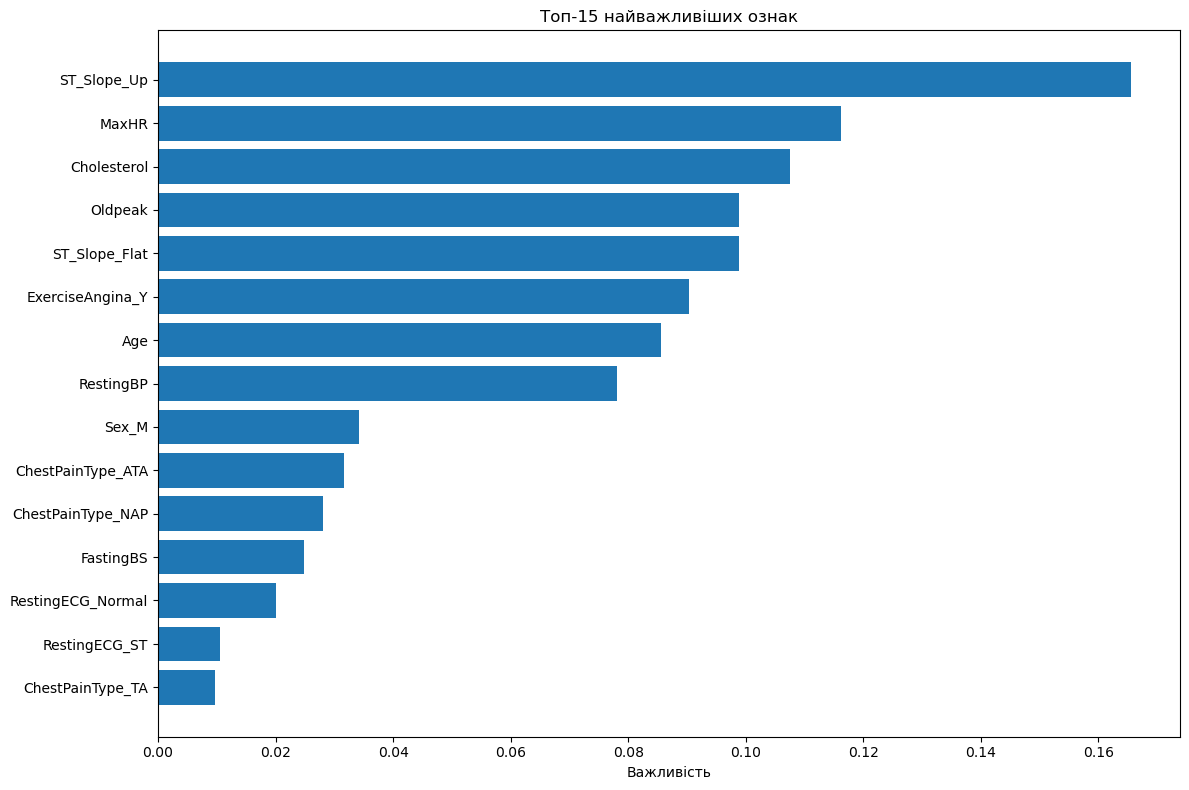


7. 3-рівневий гетерогенний ансамбль

3-рівневий гетерогенний ансамбль:
Accuracy: 0.9022
F1-score: 0.9132

8. Послідовний гетерогенний ансамбль

Послідовний ансамбль (Stacking):
Accuracy: 0.8841
F1-score: 0.8954

Підсумкове порівняння моделей

Порівняльна таблиця результатів:
                                Accuracy        F1
SVM                             0.913043  0.922581
3-Level Ensemble                0.902174  0.913183
Random Forest                   0.891304  0.903226
Parallel Ensemble (Voting)      0.887681  0.900322
Logistic Regression             0.884058  0.898089
Sequential Ensemble (Stacking)  0.884058  0.895425
Decision Tree                   0.833333  0.849673


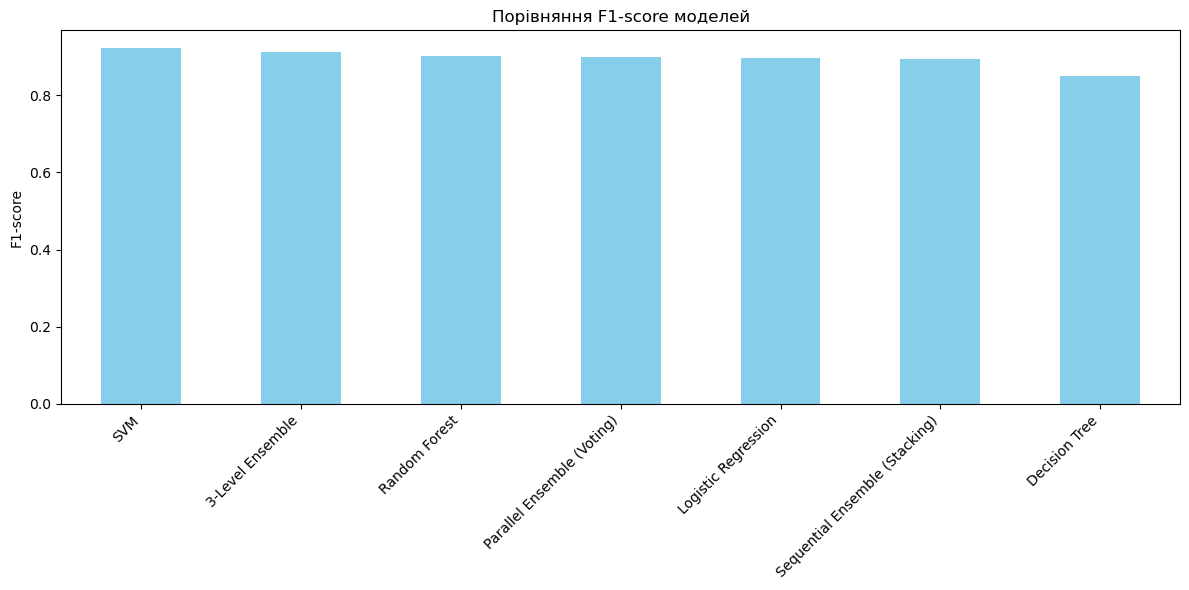

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# 1. Завантаження даних
try:
    df = pd.read_csv('heart.csv')
    print("Датасет успішно завантажено. Перші 5 рядків:")
    print(df.head())
except FileNotFoundError:
    exit()

# 2. Підготовка даних
# Визначення категоріальних та числових ознак
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numeric_features = df.select_dtypes(exclude=['object']).columns.tolist()
numeric_features.remove('HeartDisease')  # Видаляємо цільову змінну

# Створення трансформера для категоріальних та числових ознак
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Розділення на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Застосування трансформацій
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# 3. Паралельний гетерогенний ансамбль (4 моделі)
print("\n" + "="*50)
print("3. Паралельний гетерогенний ансамбль (4 моделі)")
print("="*50)

# Ініціалізація моделей
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Навчання та оцінка одиночних моделей
print("\nОцінка одиночних моделей:")
single_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    single_results[name] = {'Accuracy': acc, 'F1': f1}
    print(f"\n{name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")

# Створення паралельного ансамблю (Voting)
voting_clf = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft'
)
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)
voting_acc = accuracy_score(y_test, voting_pred)
voting_f1 = f1_score(y_test, voting_pred)

print("\nПаралельний ансамбль (Voting):")
print(f"Accuracy: {voting_acc:.4f}")
print(f"F1-score: {voting_f1:.4f}")

# 4. Різні підходи інтеграції прогнозів
print("\n" + "="*50)
print("4. Різні підходи інтеграції прогнозів")
print("="*50)

# Простий підхід: Hard Voting
hard_voting = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='hard'
)
hard_voting.fit(X_train, y_train)
hard_pred = hard_voting.predict(X_test)

print("\nHard Voting (простий підхід):")
print(f"Accuracy: {accuracy_score(y_test, hard_pred):.4f}")
print(f"F1-score: {f1_score(y_test, hard_pred):.4f}")

# Складний підхід: Weighted Soft Voting
weighted_voting = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft',
    weights=[0.2, 0.3, 0.2, 0.3]  # Приклад ваг для моделей
)
weighted_voting.fit(X_train, y_train)
weighted_pred = weighted_voting.predict(X_test)

print("\nWeighted Soft Voting (складний підхід):")
print(f"Accuracy: {accuracy_score(y_test, weighted_pred):.4f}")
print(f"F1-score: {f1_score(y_test, weighted_pred):.4f}")

# 5. Підбір оптимальних параметрів
print("\n" + "="*50)
print("5. Підбір оптимальних параметрів для ансамблю")
print("="*50)

param_grid = {
    'voting': ['soft', 'hard'],
    'weights': [
        [1, 1, 1, 1], 
        [0.2, 0.3, 0.2, 0.3],
        [0.4, 0.3, 0.2, 0.1],
        [0.1, 0.2, 0.3, 0.4]
    ]
}

grid_search = GridSearchCV(
    estimator=voting_clf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("\nНайкращі параметри:", grid_search.best_params_)
print("Найкращий F1-score (CV):", grid_search.best_score_)

best_voting = grid_search.best_estimator_
best_pred = best_voting.predict(X_test)
print("\nАнсамбль з оптимальними параметрами:")
print(f"Accuracy: {accuracy_score(y_test, best_pred):.4f}")
print(f"F1-score: {f1_score(y_test, best_pred):.4f}")

# 6. Важливість предикторів
print("\n" + "="*50)
print("6. Важливість предикторів")
print("="*50)

# Використаємо Random Forest для аналізу важливості ознак
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Отримання важливості ознак
feature_importances = pd.DataFrame({
    'Feature': numeric_features + \
               list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)),
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nТоп-10 найважливіших ознак:")
print(feature_importances.head(10))

# Візуалізація
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'][:15], feature_importances['Importance'][:15])
plt.xlabel('Важливість')
plt.title('Топ-15 найважливіших ознак')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 7. N-рівневий гетерогенний ансамбль (n=3)
print("\n" + "="*50)
print("7. 3-рівневий гетерогенний ансамбль")
print("="*50)

# Додаткові моделі для багаторівневого ансамблю
additional_models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(random_state=42)
}

# Рівень 1: Базові моделі
level1_models = [
    ('dt', models['Decision Tree']),
    ('svm', models['SVM']),
    ('knn', additional_models['KNN']),
    ('xgb', additional_models['XGBoost'])
]

# Рівень 2: Stacking з мета-моделлю (Random Forest)
level2_model = StackingClassifier(
    estimators=level1_models,
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    passthrough=True
)

# Рівень 3: Voting з найкращими моделями
final_ensemble = VotingClassifier(
    estimators=[
        ('stacking', level2_model),
        ('rf', models['Random Forest']),
        ('lr', models['Logistic Regression'])
    ],
    voting='soft'
)

# Навчання та оцінка
final_ensemble.fit(X_train, y_train)
final_pred = final_ensemble.predict(X_test)

print("\n3-рівневий гетерогенний ансамбль:")
print(f"Accuracy: {accuracy_score(y_test, final_pred):.4f}")
print(f"F1-score: {f1_score(y_test, final_pred):.4f}")

# 8. Послідовний гетерогенний ансамбль
print("\n" + "="*50)
print("8. Послідовний гетерогенний ансамбль")
print("="*50)

# Створення послідовного ансамблю (Stacking)
stacking_clf = StackingClassifier(
    estimators=[
        ('dt', models['Decision Tree']),
        ('svm', models['SVM']),
        ('knn', additional_models['KNN']),
        ('xgb', additional_models['XGBoost'])
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    passthrough=True
)
stacking_clf.fit(X_train, y_train)
stacking_pred = stacking_clf.predict(X_test)

print("\nПослідовний ансамбль (Stacking):")
print(f"Accuracy: {accuracy_score(y_test, stacking_pred):.4f}")
print(f"F1-score: {f1_score(y_test, stacking_pred):.4f}")

# Порівняння всіх моделей
print("\n" + "="*50)
print("Підсумкове порівняння моделей")
print("="*50)

all_results = {
    **single_results,
    'Parallel Ensemble (Voting)': {'Accuracy': voting_acc, 'F1': voting_f1},
    '3-Level Ensemble': {
        'Accuracy': accuracy_score(y_test, final_pred),
        'F1': f1_score(y_test, final_pred)
    },
    'Sequential Ensemble (Stacking)': {
        'Accuracy': accuracy_score(y_test, stacking_pred),
        'F1': f1_score(y_test, stacking_pred)
    }
}

results_df = pd.DataFrame(all_results).T
print("\nПорівняльна таблиця результатів:")
print(results_df.sort_values('F1', ascending=False))

# Візуалізація результатів
plt.figure(figsize=(12, 6))
results_df.sort_values('F1', ascending=False)['F1'].plot(kind='bar', color='skyblue')
plt.title('Порівняння F1-score моделей')
plt.ylabel('F1-score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()